In [1]:
!pip install mlflow

In [20]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import math
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import mlflow
from pickle import dump



In [21]:
data = pd.read_csv('fraudTest.csv')
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [23]:
data['is_fraud'].value_counts(normalize = True)
# there is 0.39 % fraud (553574 true transactions and 492 frauds)
# we have a very imbalanced dataset as the frauds account for 0.39% of all transactions. 
# ATTENTION sur la métrique à utiliser : même un dummy model trouveras une accuracy score > 99% !

0    0.99614
1    0.00386
Name: is_fraud, dtype: float64

# EDA


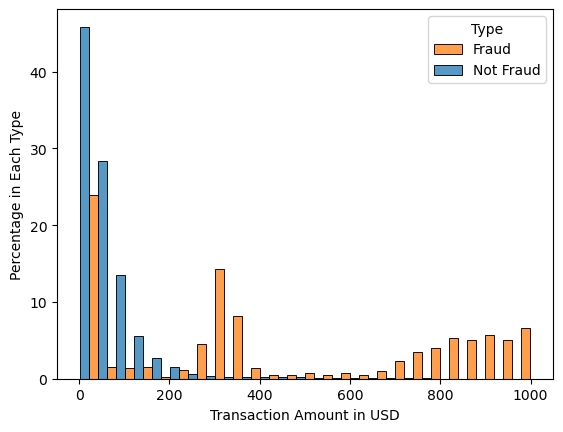

In [24]:
#amount vs fraud
ax=sns.histplot(x='amt',data=data[data.amt<=1000],hue='is_fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount in USD')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])



Text(0.5, 1.0, 'The Percentage Difference of Fraudulent over Non-Fraudulent Transations in Each Spending Category ')

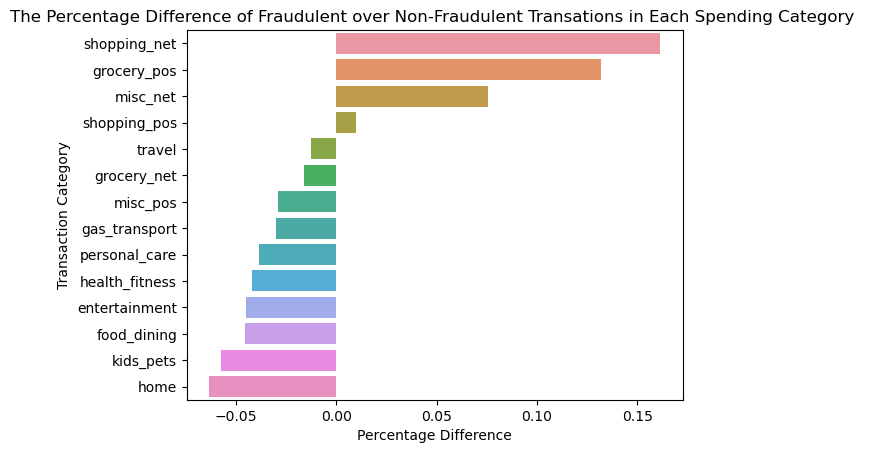

In [25]:
#calculate the percentage difference
a=data[data['is_fraud']==0]['category'].value_counts(normalize=True).to_frame().reset_index()
a.columns=['category','not fraud percentage']

b=data[data['is_fraud']==1]['category'].value_counts(normalize=True).to_frame().reset_index()
b.columns=['category','fraud percentage']
ab=a.merge(b,on='category')
ab['diff']=ab['fraud percentage']-ab['not fraud percentage']

ax=sns.barplot(y='category',x='diff',data=ab.sort_values('diff',ascending=False))
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Category')
plt.title('The Percentage Difference of Fraudulent over Non-Fraudulent Transations in Each Spending Category ')


# Pre-processing
Notes :
- Dans ce problème précis, inutile d'enlever les outliers, car en toute logique, ce sont ceux-ci qu'on essaie de détecter 
- comme on a une bdd très peu équilibrée, ne pas oublier de stratify y
- sélection des variables intéressantes :
    - calcul de la distance entre lat/long acheteur et lat/long merchant
    - age, genre
    - on se débarrasse des adresses pour ne garder que les codes postaux


In [26]:
# converting to date time
data['Date'] = pd.to_datetime(data['trans_date_trans_time'])

# Create new columns
data['day'] = data['Date'].dt.day
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year
data['weekday'] = data['Date'].dt.weekday


data['gender'] = data['gender'].apply(lambda x: 1 if x =='F' else 0)


In [27]:
# calculate age 
data['age'] = pd.to_datetime(data['dob'])
today = datetime.now()
data['age'] = ((today - data['age']) / pd.Timedelta(days=365.25)).astype(int)

In [28]:
# drop unnecessary columns
c = ['Unnamed: 0', 'trans_date_trans_time', 'Date','cc_num', 'first', 'last', 'street', 'city', 'zip', 'state', 'job', 'dob', 'trans_num']
data = data.drop(columns=c)

In [29]:
# calcul distance entre merchant and client

def haversine(lon_1, lon_2, lat_1, lat_2):
    
    lon_1, lon_2, lat_1, lat_2 = map(np.radians, [lon_1, lon_2, lat_1, lat_2])  # Convert degrees to Radians
    
    
    diff_lon = lon_2 - lon_1
    diff_lat = lat_2 - lat_1
    

    distance_km = 2*6371*np.arcsin(np.sqrt(np.sin(diff_lat/2.0)**2 + np.cos(lat_1) * np.cos(lat_2) * np.sin(diff_lon/2.0)**2)) # earth radius: 6371km
    
    return distance_km

data['transaction_distance'] = data.apply(lambda x: haversine(x.long, x.merch_long, x.lat, x.merch_lat), axis=1)

In [30]:
data.head()

,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,day,month,year,weekday,age,transaction_distance
0,fraud_Kirlin and Sons,personal_care,2.86,0,33.9659,-80.9355,333497,1371816865,33.986391,-81.200714,0,21,6,2020,6,55,24.561462
1,fraud_Sporer-Keebler,personal_care,29.84,1,40.3207,-110.4360,302,1371816873,39.450498,-109.960431,0,21,6,2020,6,33,104.925092
2,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,1,40.6729,-73.5365,34496,1371816893,40.495810,-74.196111,0,21,6,2020,6,52,59.080078
3,fraud_Haley Group,misc_pos,60.05,0,28.5697,-80.8191,54767,1371816915,28.812398,-80.883061,0,21,6,2020,6,36,27.698567
4,fraud_Johnston-Casper,travel,3.19,0,44.2529,-85.0170,1126,1371816917,44.959148,-85.884734,0,21,6,2020,6,68,104.335106


In [31]:
X = data.drop('is_fraud', axis=1)
Y = data['is_fraud']

# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.items():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)



Found numeric features  ['amt', 'gender', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'day', 'month', 'year', 'weekday', 'age', 'transaction_distance']
Found categorical features  ['merchant', 'category']


In [32]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [33]:
# Create pipeline for numeric features
numeric_transformer = StandardScaler() # Need to standardize features because we'll first use a linear regression as baseline model
categorical_transformer = OneHotEncoder(drop='first') # no missing values in categorical data, so we only need the OHE
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! 
print('...Done.')
print(X_test[0:5,:])



Performing preprocessings on train set...
                                    merchant       category     amt  gender  \
549254               fraud_Cummerata-Hilpert  entertainment  270.96       1   
264995                  fraud_Hoppe-Parisian      kids_pets    9.45       0   
300656   fraud_Denesik, Powlowski and Pouros           home  110.52       0   
524699  fraud_Baumbach, Hodkiewicz and Walsh   shopping_pos    6.18       0   
249815                      fraud_Reilly LLC           home   62.78       1   

            lat      long  city_pop   unix_time  merch_lat  merch_long  day  \
549254  37.6787 -122.4780    107941  1388360840  36.855741 -122.716984   29   
264995  41.7918  -72.7188       370  1380289125  41.922784  -72.266141   27   
300656  41.5205  -80.0573      5507  1381601155  42.417891  -79.960895   12   
524699  40.7382  -73.1297      9506  1387949241  40.069491  -73.381594   25   
249815  38.7897  -93.8702      2368  1379702358  38.861383  -94.255647   20   

        

In [34]:
dump(preprocessor, open('preprocessor.pkl', 'wb'))

# Baseline : logistic Regression

In [16]:
# Set your variables for your environment
EXPERIMENT_NAME="fraud-detection"

# Set tracking URI to your Heroku application
# mlflow.set_tracking_uri(os.environ["APP_URI"])
mlflow.set_tracking_uri("https://lead-mlflow-e5bf7ad8367e.herokuapp.com")


# Set experiment's info 
mlflow.set_experiment(EXPERIMENT_NAME)



# Get our experiment info
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

In [17]:
# Call mlflow autolog
mlflow.sklearn.autolog()

mlflow.end_run()

with mlflow.start_run(experiment_id = experiment.experiment_id):
   
    mlflow.set_tag("user", "céline")
    mlflow.set_tag("model", "logistic regression")
    mlflow.set_tag("description", "lr")


    # Train model
    print("Train model...")
    lr = LogisticRegression()
    lr.fit(X_train, Y_train)
    print("...Done.")

    print("score on training set : ", lr.score(X_train, Y_train))
    print("score on test set : ", lr.score(X_test, Y_test))

Train model...


2023/08/08 13:06:52 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
/Users/dl/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023/08/08 13:06:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: Unable to locate credentials


...Done.
score on training set :  0.9958657144463814
score on test set :  0.9959062117613187


In [18]:
# Call mlflow autolog
mlflow.sklearn.autolog()

mlflow.end_run()

with mlflow.start_run(experiment_id = experiment.experiment_id):
   
    mlflow.set_tag("user", "céline")
    mlflow.set_tag("model", "random forest classifier")
    mlflow.set_tag("description", "rfc")


    # Train model
    print("Random Forest with default hyperparameters...")
    rfc = RandomForestClassifier() # we must use a regressor here!
    rfc.fit(X_train, Y_train)
    print("...Done.")
# Print scores
    print("score on training set : ", rfc.score(X_train, Y_train))
    print("score on test set : ", rfc.score(X_test, Y_test))



Random Forest with default hyperparameters...


2023/08/08 13:07:01 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
2023/08/08 13:11:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: Unable to locate credentials


...Done.
score on training set :  0.9999977506607434
score on test set :  0.9973187936370834
